In [1]:
cd ../pipelines

/Users/mathieuchevalley/Documents/Study/ETHZ/Fall Semester 2020/Data Science lab/data_sc_lab/task_01/pipelines


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipynb.fs.full.tool_functions import *
from yellowbrick.regressor import AlphaSelection

Using TensorFlow backend.


In [3]:
df_beha = pd.read_csv('../../../data/Behavioral/AllData.csv')#, nrows=1000)

df_psd_cluster = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Cluster.csv") #, nrows=1000)
df_psd_channel = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Channel.csv") #, nrows=5)
df_spectro_cluster = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Cluster.csv") #, nrows=1000)
df_spectro_channel = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Channel.csv") #, nrows=5)

df_microstate = pd.read_csv("../../../data/EEG/RestingEEG_Microstates.csv") #, nrows=5)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (66,68,80,81,82,83,84,95,96,97,98,99,110,111,112,113,114,125,126,127,128,129,140,141,142,144,155,156,157,159,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103

In [4]:
# Extract relevant info from the Behavioral data 
y_labels = df_beha[["Patient_ID", "Age", "DX_01_Cat"]]
y_labels_healthy = y_labels[y_labels["DX_01_Cat"].str.contains("No Diagnosis Given") == True]

y_labels = y_labels[["Patient_ID", "Age"]]
y_labels_healthy = y_labels_healthy[["Patient_ID", "Age"]]
y_labels_healthy

,Patient_ID,Age
9,NDARCF462HNM,14.216632
11,NDARFC233RND,9.153661
22,NDARDT800YVF,17.510381
25,NDARZT011LBZ,7.760209
26,NDARKV482FU9,10.977298
...,...,...
2088,NDARAV069HGT,13.896189
2089,NDARZC497BFU,17.419917
2090,NDARDZ737LG9,13.031143
2094,NDARRT283RHB,10.712069


In [5]:
df_psd_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_spectro_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_microstate.rename(columns={'id': 'Patient_ID'}, inplace=True)
print("Original lengths: " + str(len(df_psd_cluster)) + "(psd), " + \
     str(len(df_spectro_cluster)) + "(spectro), " + str(len(df_microstate)) + "(micro)")

# Aggregate with label
df_label_psd_cluster = pd.merge(y_labels_healthy, df_psd_cluster, on='Patient_ID')
df_label_spectro_cluster = pd.merge(y_labels_healthy, df_spectro_cluster, on='Patient_ID')
df_label_microstate = pd.merge(y_labels_healthy, df_microstate, on='Patient_ID')
print("Only healthy people, resulting lengths: " + str(len(df_label_psd_cluster)) + "(psd), " + \
     str(len(df_label_spectro_cluster)) + "(spectro), " + str(len(df_label_microstate)) + "(micro)")

# Drop NaN values
df_label_psd_cluster = fill_with_median(df_label_psd_cluster)
df_label_spectro_cluster = fill_with_median(df_label_spectro_cluster)
df_label_microstate = fill_with_median(df_label_microstate)
print("Replace NaN by median, resulting lenghts: " + str(len(df_label_psd_cluster)) + "(psd), " + \
     str(len(df_label_spectro_cluster)) + "(spectro), " + str(len(df_label_microstate)) + "(micro)")

Original lengths: 1485(psd), 1485(spectro), 1108(micro)
Only healthy people, resulting lengths: 174(psd), 174(spectro), 128(micro)
Replace NaN by median, resulting lenghts: 174(psd), 174(spectro), 128(micro)


In [6]:
less_18 = df_label_spectro_cluster['Age'] <= 18.0
df_label_spectro_cluster = df_label_spectro_cluster[less_18]

In [7]:
test_ratio = 0.2

In [8]:
df_label_spectro_cluster.columns

Index(['Patient_ID', 'Age', 'eyesclosed_fband_delta_absmean_lfront',
       'eyesclosed_fband_delta_absmean_mfront',
       'eyesclosed_fband_delta_absmean_rfront',
       'eyesclosed_fband_delta_absmean_lpari',
       'eyesclosed_fband_delta_absmean_mpari',
       'eyesclosed_fband_delta_absmean_rpari',
       'eyesclosed_fband_delta_relmean_lfront',
       'eyesclosed_fband_delta_relmean_mfront',
       ...
       'eyesopen_fooof_peak_freq_rfront', 'eyesopen_fooof_peak_freq_lpari',
       'eyesopen_fooof_peak_freq_mpari', 'eyesopen_fooof_peak_freq_rpari',
       'eyesopen_fooof_peak_amplitude_lfront',
       'eyesopen_fooof_peak_amplitude_mfront',
       'eyesopen_fooof_peak_amplitude_rfront',
       'eyesopen_fooof_peak_amplitude_lpari',
       'eyesopen_fooof_peak_amplitude_mpari',
       'eyesopen_fooof_peak_amplitude_rpari'],
      dtype='object', length=302)

In [9]:
fband_absmean = df_label_spectro_cluster.columns.str.contains("_fband_.*_relmean_", regex=True)
eyesclosed = df_label_spectro_cluster.columns.str.startswith("eyesclosed_fooof_")
unique = df_label_spectro_cluster.columns.str.startswith("eyesclosed_alphapeak_max_freq")
y_train_df = df_label_spectro_cluster.loc[:,'Age']
#df_label_spectro_cluster[fband_absmean | eyesclosed | unique].columns
x_spev2 = df_label_spectro_cluster.loc[:, fband_absmean | eyesclosed | unique]

In [10]:
from sklearn.model_selection import train_test_split
x_train , x_test, y_train , y_test = train_test_split(x_spev2,y_train_df,test_size=0.2, random_state = 0)

In [11]:
forest = IsolationForest()
forest.fit(x_train)

# Outlier indices for training
outliers_training = forest.predict(x_train)
outliers_training_indices = np.argwhere(outliers_training == 1).flatten()

# Drop signal outliers in training data
x_train = x_train[outliers_training == 1]
y_train = y_train[outliers_training == 1]

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [12]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)

In [13]:
def fit_xgboost_with_grid_search(X_train, y_train):

    # Create gradient boosting object
    xgbr = XGBRegressor(verbosity=1, max_depth=10, reg_lambda=1) 
    
    # Grid search 
    parameters = {'max_depth':[1,2,4], 'reg_lambda':[4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_child_weight':[6, 8, 12,16, 20, 25, 30]}
    clf = GridSearchCV(xgbr, parameters, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
    clf.fit(X_train, y_train)
    
    print("Best parameters for XGBoost: " + str(clf.best_params_))
            
    return clf

In [14]:
xb_boost = fit_xgboost_with_grid_search(x_train, y_train)

Best parameters for XGBoost: {'max_depth': 1, 'min_child_weight': 12, 'reg_lambda': 4}


In [15]:
xb_boost.best_score_

-4.274629809695336

In [16]:
xgbr = XGBRegressor(verbosity=1, max_depth=1, min_child_weight= 6, reg_lambda=4) 
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=4, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

In [17]:
import sklearn
test_mse_xg = sklearn.metrics.mean_squared_error(y_test , xgbr.predict(x_test))
print('TEST MSE = ', test_mse_xg)

TEST MSE =  6.033776826589398


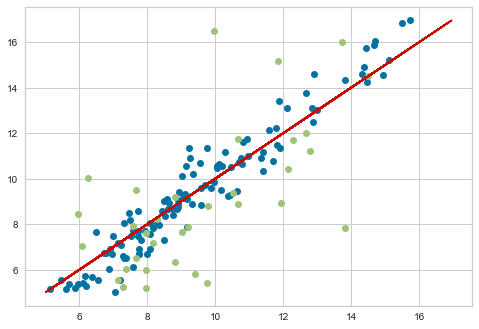

In [18]:
plt.plot(xgbr.predict(x_train) , y_train , 'o')
plt.plot(xgbr.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

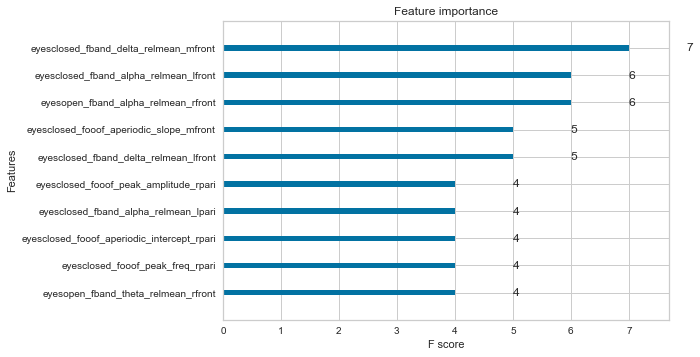

In [19]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgbr, max_num_features=10)
pyplot.show()

In [20]:
from sklearn import svm
svr= svm.SVR()
parameters = {'kernel' : ( 'rbf' , 'poly', 'linear', 'sigmoid' ), 'C':[0.1, 1,10,100], 'gamma':['auto', 10e-2, 10e-1, 1, 2]}
clf = GridSearchCV(svr, parameters ,cv =5, scoring='neg_mean_squared_error')
clf.fit(x_train , y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['auto', 0.1, 1.0, 1, 2],
                         'kernel': ('rbf', 'poly', 'linear', 'sigmoid')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [21]:
print(clf.best_estimator_)
best_param = clf.best_params_
print("Best score = " , clf.best_score_)
print("Best param = " , best_param)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best score =  -4.531440044383158
Best param =  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


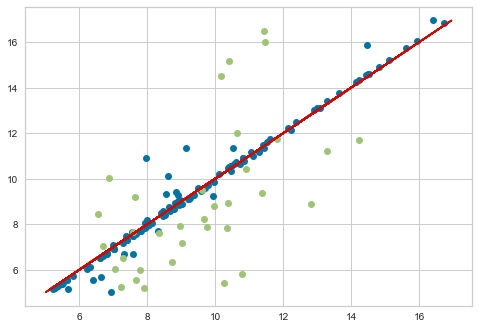

In [22]:
plt.plot(clf.predict(x_train) , y_train , 'o')
plt.plot(clf.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

In [23]:
svr_final = svm.SVR(kernel = best_param['kernel'] , C = best_param['C'])
svr_final.fit(x_train , y_train)
test_mse_svm = sklearn.metrics.mean_squared_error(y_test , svr_final.predict(x_test))
print('TEST MSE = ', test_mse_svm)

TEST MSE =  6.783116951997001


In [24]:
gpr = GaussianProcessRegressor(n_restarts_optimizer=5)
    
# Grid search
parameters = {
    'kernel': [RationalQuadratic(), RBF(), Matern(length_scale=1, nu=1.5),  DotProduct()], 'alpha': [1e-10, 1e-5, 1e-3, 1e-1, 1., 1.5, 2.]}
clf_gpr = GridSearchCV(gpr, parameters, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
clf_gpr.fit(x_train, y_train)
clf_gpr.best_params_

{'alpha': 0.1, 'kernel': Matern(length_scale=1, nu=1.5)}

In [25]:
clf_gpr.best_score_

-5.4001544481572346

In [26]:
sklearn.metrics.mean_squared_error(y_test , clf_gpr.predict(x_test))

12.052755899765664

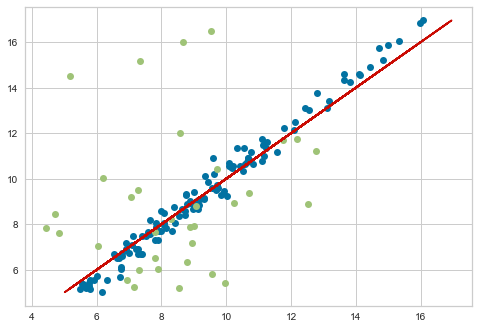

In [27]:
plt.plot(clf_gpr.predict(x_train) , y_train , 'o')
plt.plot(clf_gpr.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

In [28]:
rdf = fit_random_forest_with_grid_search(x_train, y_train)

Best parameters for Random Forest: {'max_depth': 25, 'max_leaf_nodes': 100, 'min_samples_split': 2, 'n_estimators': 1000}


In [29]:
rdf.best_params_

{'max_depth': 25,
 'max_leaf_nodes': 100,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [30]:
rdf.best_score_

-4.531019428001352

In [31]:
sklearn.metrics.mean_squared_error(y_test , rdf.predict(x_test))

6.449824110421706

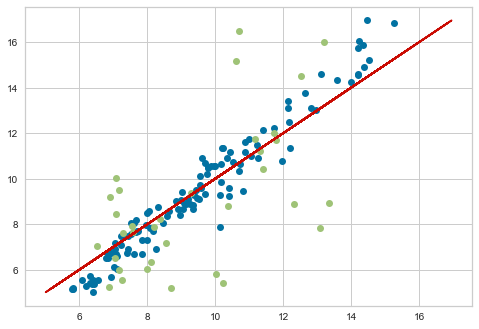

In [32]:
plt.plot(rdf.predict(x_train) , y_train , 'o')
plt.plot(rdf.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)